<a href="https://colab.research.google.com/github/Nabila310/2025_Visi-Komputer_TI2A/blob/main/Jobsheet_03_Teknik_Regresi_Gambar_D3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload()  # pilih file kaggle.json dari komputer Anda


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilaramadani","key":"9783115b33e8e7597deb58fbc73c83d9"}'}

Langkah 1

In [1]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("❌ kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving petfinder-pawpularity-score.zip to petfinder-pawpularity-score.zip
❌ kaggle.json belum ditemukan. Upload terlebih dahulu.


Langkah 2

In [8]:
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ Dataset Pawpularity berhasil diekstrak.


Langkah 3

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

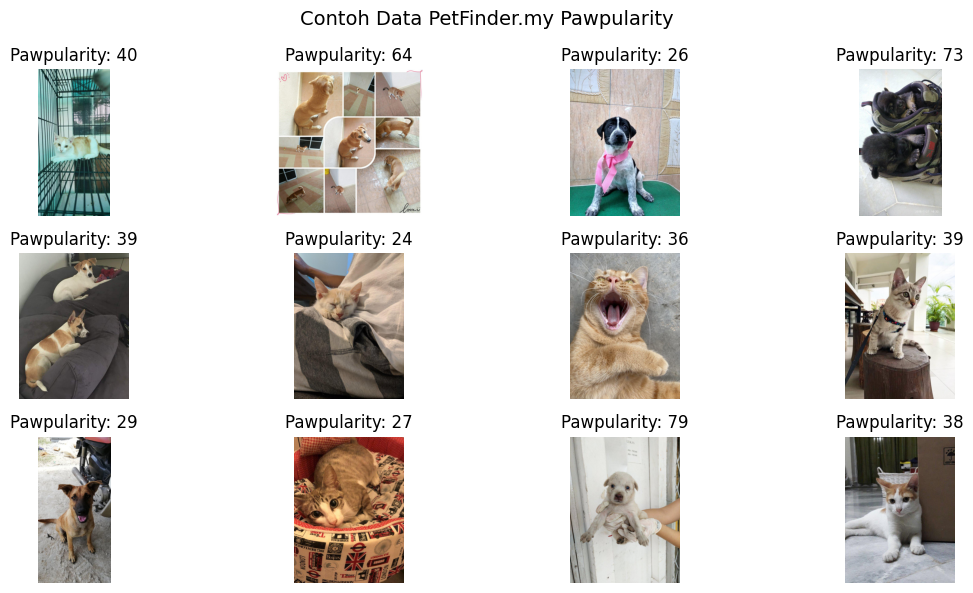

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Langkah 4

In [27]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"✅ Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


✅ Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


Langkah 5

In [26]:
from tensorflow.keras import layers, models
import tensorflow as tf

IMG_SIZE = 224

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

# ✅ Baris ini yang diperbaiki
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Langkah 6

In [3]:
cb = [
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        monitor='val_loss',
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

model.save('/content/model_pawpularity.h5')
print("✅ Model Pawpularity berhasil disimpan sebagai model_pawpularity.h5")


NameError: name 'model' is not defined

Langkah 7

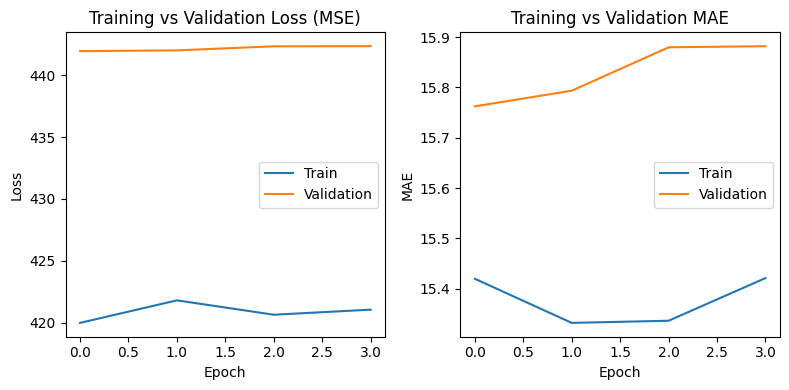

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


Langkah 8

MAE  = 15.85
RMSE = 21.03
R²   = -0.000


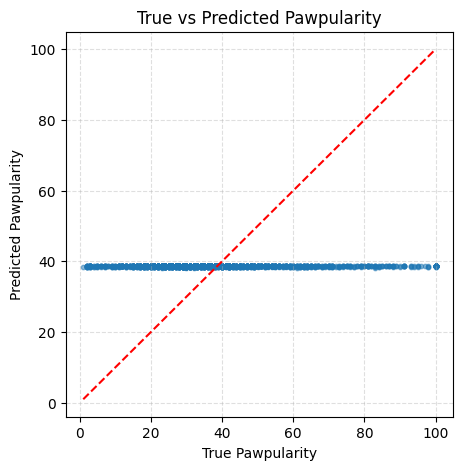

In [32]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


In [20]:
# Simpan model setelah training selesai
model.save('/content/model_pawpularity.h5')
print("✅ Model disimpan sebagai model_pawpularity.h5")


✅ Model disimpan sebagai model_pawpularity.h5


Tantangan Mini

1

In [15]:
from tensorflow.keras import layers

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

def load_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    img = augment(img)
    return img, tf.cast(label, tf.float32)

train_ds_aug = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

model.fit(train_ds_aug, validation_data=val_ds, epochs=5)


Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 116s 530ms/step - loss: 345.0412 - mae: 13.7677 - val_loss: 357.7663 - val_mae: 13.8627
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 111s 497ms/step - loss: 329.1917 - mae: 13.5811 - val_loss: 362.6354 - val_mae: 14.2147
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 114s 521ms/step - loss: 340.4306 - mae: 13.7813 - val_loss: 361.6410 - val_mae: 13.7240
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 138s 490ms/step - loss: 340.4749 - mae: 13.7633 - val_loss: 361.7395 - val_mae: 13.8068
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 114s 521ms/step - loss: 326.2837 - mae: 13.3567 - val_loss: 358.5493 - val_mae: 13.9196


2

In [16]:
from tensorflow.keras import layers, models

base_b3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_b3.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_b3.fit(train_ds, validation_data=val_ds, epochs=5)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 695ms/step - loss: 928.1951 - mae: 22.9897 - val_loss: 486.6835 - val_mae: 16.1565
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 268ms/step - loss: 451.0780 - mae: 15.6709 - val_loss: 414.3765 - val_mae: 15.0491
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - loss: 399.4993 - mae: 14.9228 - val_loss: 389.4970 - val_mae: 14.8567
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 263ms/step - loss: 365.1176 - mae: 14.3343 - val_loss: 377.8688 - val_mae: 14.3227
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - loss: 354.3205 - mae: 14.1006 - val_loss: 368.5692 - val_mae: 14.2090


3

In [17]:
if 'Type' in df.columns:
    df['Type_name'] = df['Type'].map({1: 'Dog', 2: 'Cat'})
    print(df['Type_name'].value_counts())

    df_dog = df[df['Type'] == 1]
    df_cat = df[df['Type'] == 2]

    def make_ds(sub_df):
        return tf.data.Dataset.from_tensor_slices((sub_df['path'], sub_df['Pawpularity'])) \
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
            .batch(64).prefetch(tf.data.AUTOTUNE)

    dog_ds = make_ds(df_dog)
    cat_ds = make_ds(df_cat)

    def eval_ds(ds, name):
        y_t = np.concatenate([b[1].numpy() for b in ds])
        y_p = np.concatenate([model.predict(b[0], verbose=0).ravel() for b in ds])
        mae = mean_absolute_error(y_t, y_p)
        print(f"{name} MAE = {mae:.3f}")

    eval_ds(dog_ds, "Dog")
    eval_ds(cat_ds, "Cat")
else:
    print("Kolom 'Type' tidak ditemukan pada dataset.")


Kolom 'Type' tidak ditemukan pada dataset.


4

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

def compute_brightness(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return tf.reduce_mean(img).numpy()

df['brightness'] = df['path'].apply(lambda p: compute_brightness(p))

def load_with_feat(path, label, brightness):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return (img, brightness), tf.cast(label, tf.float32)

paths = df['path'].values
labels = df['Pawpularity'].values.astype(np.float32)
brights = df['brightness'].values.astype(np.float32)

ds_feat = tf.data.Dataset.from_tensor_slices((paths, labels, brights)).map(
    lambda p, l, b: load_with_feat(p, l, b), num_parallel_calls=tf.data.AUTOTUNE
).batch(32).prefetch(tf.data.AUTOTUNE)

# Custom layer to reshape scalar input
class ReshapeFeature(layers.Layer):
    def call(self, inputs):
        return tf.reshape(inputs, (-1, 1))

# Model dengan dua input
image_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
feat_input = tf.keras.Input(shape=(), name='feature_input')

base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
x = base(image_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)

# Reshape the feature input using the custom layer
reshaped_feat = ReshapeFeature()(feat_input)

merged = layers.Concatenate()([x, reshaped_feat])
merged = layers.Dense(128, activation='relu')(merged)
out = layers.Dense(1)(merged)

model_feat = tf.keras.Model(inputs=[image_input, feat_input], outputs=out)
model_feat.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_feat.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_feature     │ (None, 1)         │          0 │ feature_input[0]… │
│ (ReshapeFeature)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 257)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ reshape_feature[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     33,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        129 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,410,660 (16.83 MB)

 Trainable params: 4,368,637 (16.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

Penugasan 4

In [4]:
# ==========================================================
# 💡 PENUGASAN JOBSHEET 03 - TUGAS 4
# Prediksi Pawpularity dari Foto Hewan Sendiri (Model D3)
# ==========================================================

import os
from google.colab import files
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# ==========================================================
# 🔹 1️⃣ Cek dan muat model hasil Praktikum D3
# ==========================================================

model_path = '/content/model_pawpularity.h5'

# Jika file belum ada → otomatis minta upload
if not os.path.exists(model_path):
    print("⚠️ File model_pawpularity.h5 belum ditemukan di /content.")
    print("📤 Silakan upload file model hasil praktikum D3 (format .h5)")
    uploaded = files.upload()
    model_path = '/content/model_pawpularity.h5'

# Load model
model_paw = load_model(model_path)
print("✅ Model Pawpularity berhasil dimuat.\n")

# ==========================================================
# 🐶 2️⃣ Upload Foto Hewan Sendiri
# ==========================================================

print("📤 Silakan upload foto hewan peliharaan kamu (misal: kucingku.jpg)")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# ==========================================================
# 🧠 3️⃣ Preprocessing Gambar
# ==========================================================

IMG_SIZE = 224
img = Image.open(image_path).convert('RGB')
img_resized = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img_resized) / 255.0
img_tensor = np.expand_dims(img_array, axis=0)

# ==========================================================
# 📈 4️⃣ Prediksi Pawpularity
# ==========================================================

predicted_score = model_paw.predict(img_tensor, verbose=0)[0][0]
predicted_score = np.clip(predicted_score, 0, 100)

# ==========================================================
# 🎨 5️⃣ Tampilkan Hasil Prediksi
# ==========================================================

plt.figure(figsize=(5,5))
plt.imshow(img_resized)
plt.title(f"Pawpularity: {predicted_score:.2f}/100", fontsize=12)
plt.axis('off')
plt.show()

print("🐾 HASIL PREDIKSI FOTO HEWAN")
print("-----------------------------")
print(f"Nama File Gambar : {image_path}")
print(f"Skor Pawpularity : {predicted_score:.2f}/100")
print("-----------------------------")
print("✅ Selesai! Gunakan hasil ini di laporan (Tugas 4).")


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}